Rumore stimato = 1.952e-02

Stima Monte Carlo:
⟨delta⟩ = 0.02546, σ_delta = 0.00086


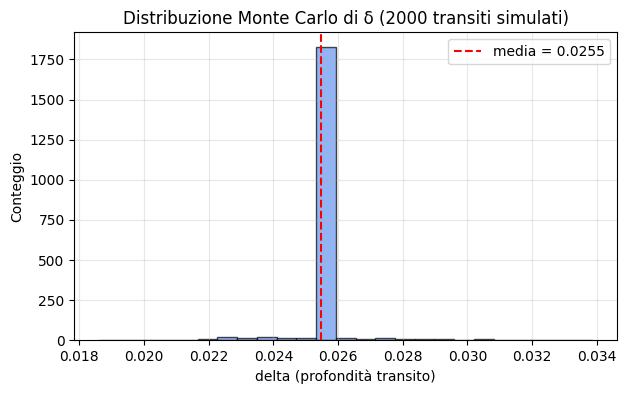

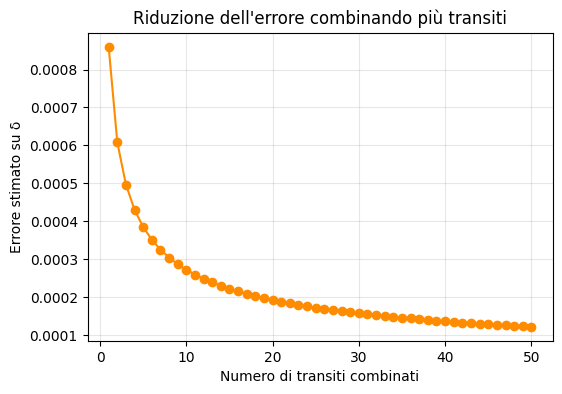


 combinanzione transiti:
 1 transiti errore su δ ≈ 0.00086
 2 transiti errore su δ ≈ 0.00061
 5 transiti errore su δ ≈ 0.00038
10 transiti errore su δ ≈ 0.00027
20 transiti errore su δ ≈ 0.00019
50 transiti errore su δ ≈ 0.00012


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# ===============================
file_path = "VarAstro_Star_61740_Obs_110560_2025-10-20.txt"
data = pd.read_csv(file_path, comment="#", sep=r"\s+", names=["JD","mag_rel"],skiprows=1)
data["JD"]=pd.to_numeric(data["JD"], errors="coerce")
data["mag_rel"]=pd.to_numeric(data["mag_rel"], errors="coerce")
data.dropna()

t=data["JD"]
data["flux"] = 10 ** (-0.4 * data["mag_rel"])

# modello trapezoidale lineare
def trapezoid_linear(t, t0, delta, T, tau, F0):
    t1, t2, t3, t4 = t0 - 0.5*T, t0 - 0.5*T + tau, t0 + 0.5*T - tau, t0 + 0.5*T
    F = np.full_like(t, F0)
    F[(t >= t1) & (t < t2)] = F0 - delta * (t[(t >= t1) & (t < t2)] - t1) / tau
    F[(t >= t2) & (t <= t3)] = F0 - delta
    F[(t > t3) & (t <= t4)] = F0 - delta * (1 - (t4 - t[(t > t3) & (t <= t4)]) / tau)
    return F

#Parametri iniziali individuati dal best fit
params_best = dict(
    t0=2460957.36047,
    delta=0.02548,
    T=0.03130,
    tau=0.00570,
    F0=1.00784)

# Rumore residui
resid_real = data["flux"]- trapezoid_linear(t, **params_best)
sigma_noise = np.std(resid_real)
print(f"Rumore stimato = {sigma_noise:.3e}")


#  Monte Carlo: simula più transiti

N_transiti = 2000   # numero di simulazioni
deltas = []

for i in range(N_transiti):
    flux_sim = trapezoid_linear(t, **params_best) + np.random.normal(0, sigma_noise, size=len(t))
    
    p0 = [params_best["t0"], params_best["delta"], params_best["T"], params_best["tau"], params_best["F0"]]
    bounds = (
        [t.min(), 0, 0, 0, 0.5],
        [t.max(), 0.5, (t.max()-t.min()), (t.max()-t.min())/2, 2.0]
    )
    try:
        popt, _ = curve_fit(trapezoid_linear, t, flux_sim, p0=p0, bounds=bounds, maxfev=50000)
        deltas.append(popt[1])
    except RuntimeError:
        
        continue

deltas = np.array(deltas)
mean_delta, std_delta = np.mean(deltas), np.std(deltas)
print(f"\nStima Monte Carlo:")
print(f"⟨delta⟩ = {mean_delta:.5f}, σ_delta = {std_delta:.5f}")


plt.figure(figsize=(7,4))
plt.hist(deltas, bins=25, color="cornflowerblue", alpha=0.7, edgecolor="black")
plt.axvline(mean_delta, color="red", linestyle="--", label=f"media = {mean_delta:.4f}")
plt.xlabel("delta (profondità transito)")
plt.ylabel("Conteggio")
plt.title(f"Distribuzione Monte Carlo di δ ({N_transiti} transiti simulati)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


N_stack = np.arange(1, 51)
err_reduced = std_delta / np.sqrt(N_stack)

plt.figure(figsize=(6,4))
plt.plot(N_stack, err_reduced, "-o", color="darkorange")
plt.xlabel("Numero di transiti combinati")
plt.ylabel("Errore stimato su δ")
plt.title("Riduzione dell'errore combinando più transiti")
plt.grid(alpha=0.3)
plt.show()

print("\n combinanzione transiti:")
for n in [1, 2, 5, 10, 20, 50]:
    print(f"{n:2d} transiti errore su δ ≈ {std_delta/np.sqrt(n):.5f}")
